In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from time import time
import tensorflow
from tensorflow.keras import models
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler

In [2]:
fred_md = pd.read_csv("data/Fred_MD_Current.csv")
fred_md.drop(0,axis=0, inplace=True) #Dropping the first row because it contains the transfotmation values. For this data look at fred_md_metadata.tcode.
fred_md.set_index("sasdate", inplace=True)
fred_md_metadata = pd.read_csv("data/FRED-MD_Metadata.csv", encoding='iso-8859-1')
fred_md.index = pd.to_datetime(fred_md.index)
fred_md.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9665,23.3891,22.2688,31.7011,19.0149,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
1959-02-01,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3966,23.7048,22.4617,31.9337,19.1147,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
1959-03-01,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7193,23.8483,22.5719,31.9337,19.4890,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
1959-04-01,2627.446,2470.0,15.435,283362.7075,18534.46600,23.2032,24.1927,22.9026,32.4374,19.6138,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
1959-05-01,2642.720,2486.4,15.622,285307.2201,18679.66354,23.5528,24.3936,23.1231,32.5925,20.0130,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN


In [290]:
# Functions for formatting data
# Taken from https://colab.research.google.com/drive/1b3CUJuDOmPmNdZFH3LQDmt5F0K3FZhqD?usp=sharing#scrollTo=7EViSFyntz9j
def format_multiple_variables(df, window_size=5, label_index=-1):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][label_index]
        y.append(label)
    return np.array(X), np.array(y)

def format_one_variable(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [a for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

# My own functions
def df_scaling(df):
    scaler_fn = StandardScaler()
    scaled_np = scaler_fn.fit_transform(df.to_numpy())
    scaled_df = pd.DataFrame(scaled_np, columns = df.columns)
    scaled_df.index = df.index
    return scaled_df, scaler_fn

def back_scaling(og_df, df_of_preds):
    scaled_df, scaler_fn = df_scaling(og_df)
    df_of_preds_np = scaler_fn.inverse_transform(df_of_preds.to_numpy())
    df_of_preds_df = pd.DataFrame(df_of_preds_np, columns=df_of_preds.columns)
    df_of_preds_df.index = df_of_preds.index
    return df_of_preds_df

def train_val_test(x_array, y_array, train_stop, val_stop):
    x_train, x_val, x_test = x_array[:train_stop], x_array[train_stop:val_stop], x_array[val_stop:]
    y_train, y_val, y_test = y_array[:train_stop], y_array[train_stop:val_stop], y_array[val_stop:]
    return x_train, x_val, x_test, y_train, y_val, y_test
    

In [68]:
urate_dollar_df = fred_md[["EXSZUSx", "EXJPUSx", "EXUSUKx", "EXCAUSx", "UNRATE"]]
frequency = pd.infer_freq(fred_md.index)
urate_dollar_df.index = pd.DatetimeIndex(fred_md.index, freq=frequency)
urate_dollar_df.head()

,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,UNRATE
sasdate,,,,,
1959-01-01,4.3122,359.8417,2.8065,0.9671,6.0
1959-02-01,4.3133,359.8417,2.8093,0.9748,5.9
1959-03-01,4.3228,359.8417,2.8127,0.9698,5.6
1959-04-01,4.3226,359.8417,2.8165,0.9636,5.2
1959-05-01,4.3228,359.8417,2.8145,0.9630,5.1


### Exchange Rates and Unemployment

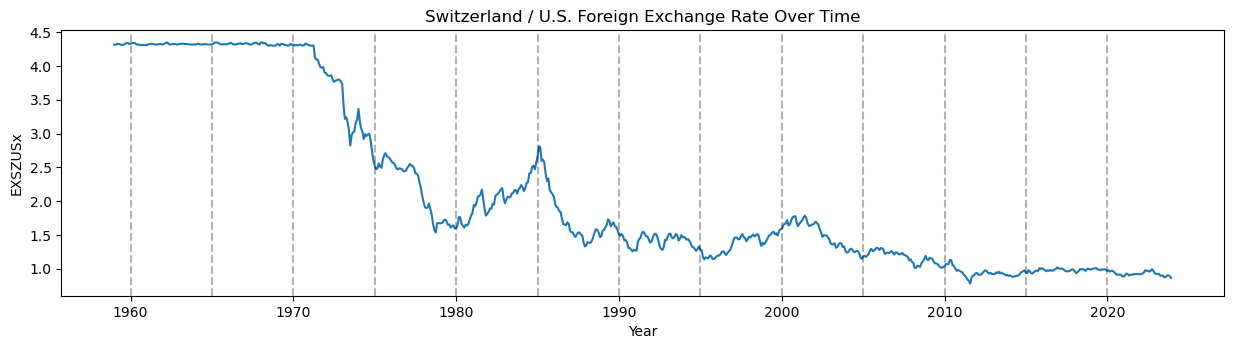

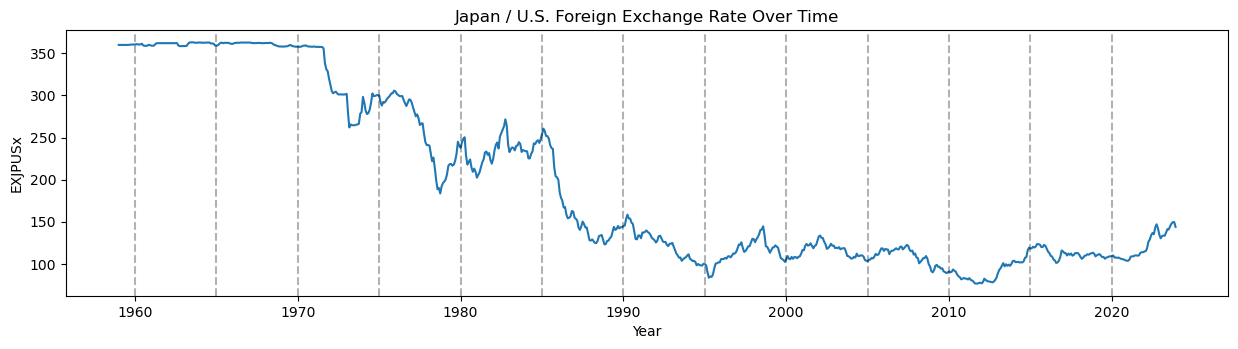

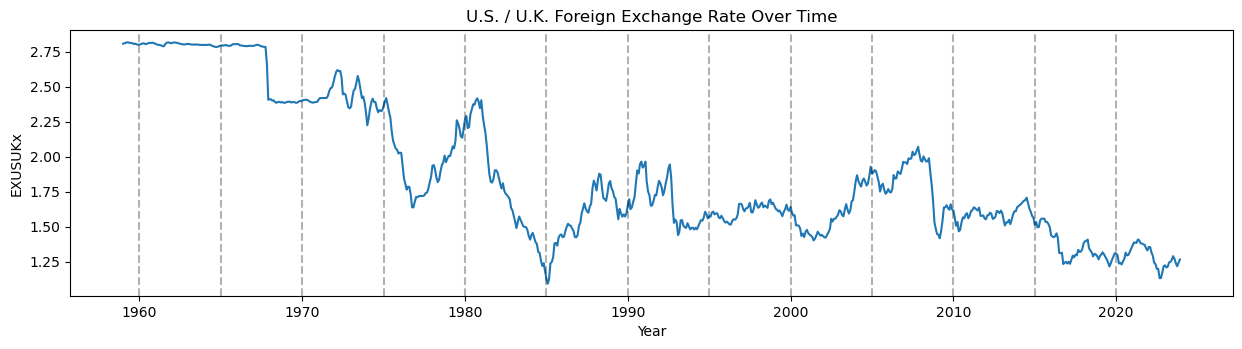

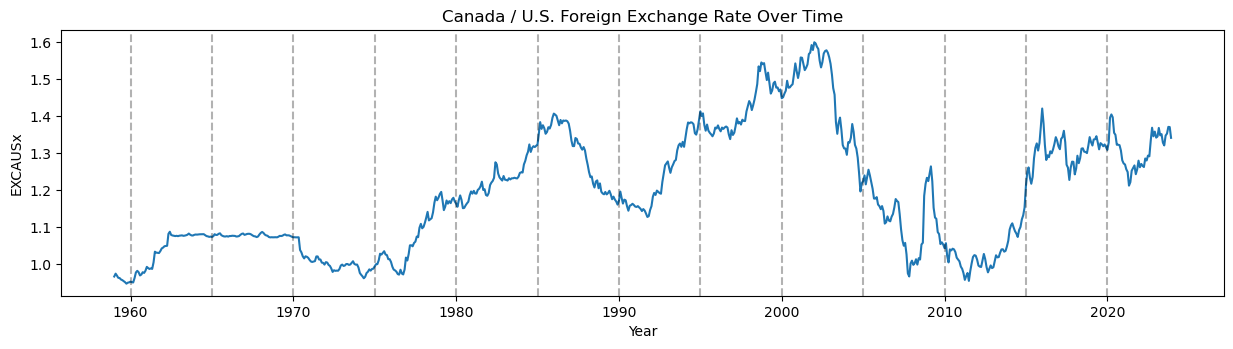

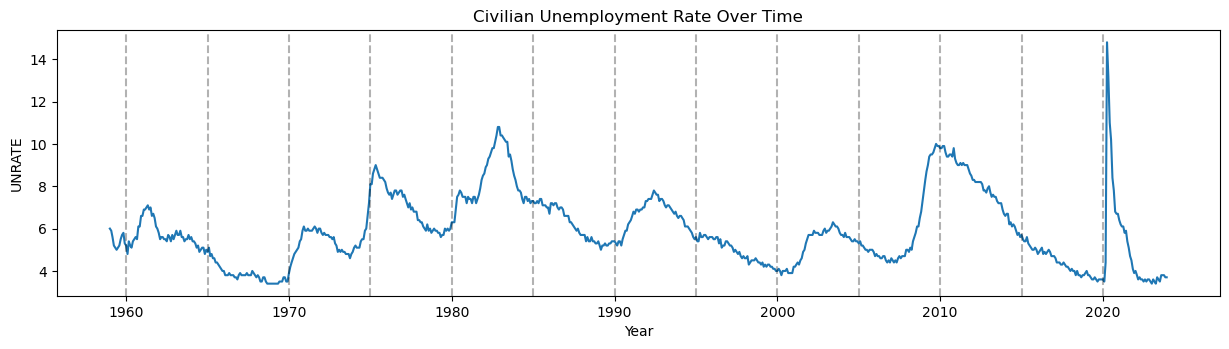

In [23]:
count = 1
for column in urate_dollar_df.columns:
    title_ = fred_md_metadata.loc[fred_md_metadata["fred"] == column, "description"].values[0]
    plt.figure(figsize=(15,20))
    plt.subplot(len(urate_dollar_df.columns), 1, count)
    plt.plot(urate_dollar_df[column])
    plt.title(f"{title_} Over Time")
    plt.xlabel("Year")
    plt.ylabel(f"{column}")
    for year in range (urate_dollar_df.index[0].year+1,urate_dollar_df.index[-1].year +1, 5):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)
    count += 1

__Takeaways From The Plots:__

1. There don't seem to be any seasonal patterns in any of these measures.
2. In terms of the relationship between the U.S. dollar and Japanese, English, and Swiss currencies, the U.S. dollar seemed to have been considerably stronger until the 1970s. Since then, the relationships have fluctuated -- perhaps because the U.S. began importing more goods. However, it should still be noted that the U.S. dollar has been consistently stronger than these other currencies.
3. There is a major spike in unemployment in 2020 due to COVID-19; it will be interesting to see how the various Neural Networks react to this spike.

In [67]:
urate_scaled, urate_scaler = df_scaling(urate_dollar_df)
urate_scaled

,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,UNRATE
sasdate,,,,,
1959-01-01,1.778506,1.626809,1.877341,-1.414157,0.054052
1959-02-01,1.779390,1.626809,1.882991,-1.366510,-0.005413
1959-03-01,1.787025,1.626809,1.889852,-1.397450,-0.183806
1959-04-01,1.786864,1.626809,1.897519,-1.435815,-0.421664
1959-05-01,1.787025,1.626809,1.893484,-1.439528,-0.481129
...,...,...,...,...,...
2023-08-01,-0.981287,-0.487027,-1.221808,0.941591,-1.254167
2023-09-01,-0.964168,-0.456905,-1.287387,0.974387,-1.254167
2023-10-01,-0.961034,-0.439721,-1.328954,1.086389,-1.254167


In [240]:
cnn_x_sz, cnn_y_sz = format_multiple_variables(urate_scaled[["EXSZUSx", "UNRATE"]], window_size = 5, label_index=0)
cnn_x_jp, cnn_y_jp = format_multiple_variables(urate_scaled[["EXJPUSx", "UNRATE"]], window_size = 5, label_index=0)
cnn_x_uk, cnn_y_uk = format_multiple_variables(urate_scaled[["EXUSUKx", "UNRATE"]], window_size = 5, label_index=0)
cnn_x_ca, cnn_y_ca = format_multiple_variables(urate_scaled[["EXCAUSx", "UNRATE"]], window_size = 5, label_index=0)
cnn_x_ca.shape

(775, 5, 2)

In [241]:
cnn_x_sz_train, cnn_x_sz_val, cnn_x_sz_test, cnn_y_sz_train, cnn_y_sz_val, cnn_y_sz_test = train_val_test(cnn_x_sz, cnn_y_sz, 500, 600)
cnn_x_jp_train, cnn_x_jp_val, cnn_x_jp_test, cnn_y_jp_train, cnn_y_jp_val, cnn_y_jp_test = train_val_test(cnn_x_jp, cnn_y_jp, 500, 600)
cnn_x_uk_train, cnn_x_uk_val, cnn_x_uk_test, cnn_y_uk_train, cnn_y_uk_val, cnn_y_uk_test = train_val_test(cnn_x_uk, cnn_y_uk, 500, 600)
cnn_x_ca_train, cnn_x_ca_val, cnn_x_ca_test, cnn_y_ca_train, cnn_y_ca_val, cnn_y_ca_test = train_val_test(cnn_x_ca, cnn_y_ca, 500, 600)

In [242]:
def create_cnn():
    CNN = models.Sequential()
    CNN.add(InputLayer((5, 2)))
    CNN.add(Conv1D(64, kernel_size = 2, activation = "tanh"))
    CNN.add(Flatten())
    CNN.add(Dense(1, "linear"))
    CNN.compile(optimizer='adam', loss='mse')
    return CNN

cnn_sz = create_cnn()
cnn_jp = create_cnn()
cnn_uk = create_cnn()
cnn_ca = create_cnn()

In [243]:
cnn_sz.fit(cnn_x_sz_train, cnn_y_sz_train, validation_data = (cnn_x_sz_val, cnn_y_sz_val),epochs=25)
print("SZ done")
cnn_jp.fit(cnn_x_jp_train, cnn_y_jp_train, validation_data = (cnn_x_jp_val, cnn_y_jp_val),epochs=25)
print("JP done")
cnn_uk.fit(cnn_x_uk_train, cnn_y_uk_train, validation_data = (cnn_x_uk_val, cnn_y_uk_val),epochs=25)
print("UK done")
cnn_ca.fit(cnn_x_ca_train, cnn_y_ca_train, validation_data = (cnn_x_ca_val, cnn_y_ca_val),epochs=25)
print("CA done")

Epoch 1/25
16/16 [==============================] - 1s 15ms/step - loss: 0.2241 - val_loss: 0.0483
Epoch 2/25
16/16 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.0034
Epoch 3/25
16/16 [==============================] - 0s 4ms/step - loss: 0.0102 - val_loss: 0.0034
Epoch 4/25
16/16 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.0015
Epoch 5/25
16/16 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 6/25
16/16 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0017
Epoch 7/25
16/16 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0015
Epoch 8/25
16/16 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 9/25
16/16 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0017
Epoch 10/25
16/16 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 11/25
16/16 

In [244]:
sz_preds = cnn_sz.predict(cnn_x_sz_test)
jp_preds = cnn_jp.predict(cnn_x_jp_test)
uk_preds = cnn_uk.predict(cnn_x_uk_test)
ca_preds = cnn_ca.predict(cnn_x_ca_test)

6/6 [==============================] - 0s 4ms/step


In [245]:
preds_dict = {
    "sz_preds":sz_preds.reshape(1,-1)[0],
    "jp_preds":jp_preds.reshape(1,-1)[0],
    "uk_preds":uk_preds.reshape(1,-1)[0],
    "ca_preds":ca_preds.reshape(1,-1)[0],
    "urate":urate_scaled.iloc[600+5:,-1],
}
preds_df = pd.DataFrame(preds_dict)
unscaled_preds_df = back_scaling(urate_dollar_df, preds_df)


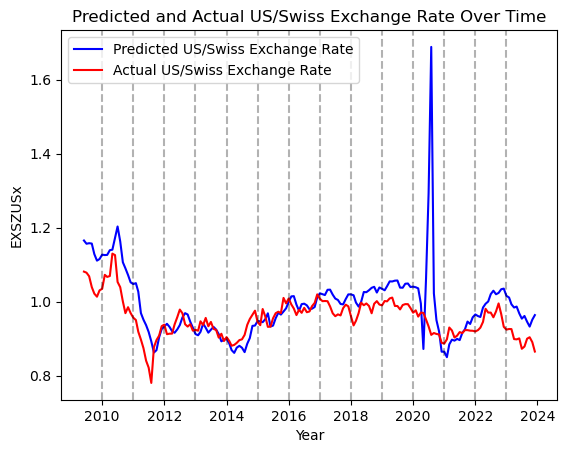

In [246]:
plt.plot(unscaled_preds_df["sz_preds"], color = "blue", label = "Predicted US/Swiss Exchange Rate")
plt.plot(urate_dollar_df["EXSZUSx"][600+5:], color = "red", label = "Actual US/Swiss Exchange Rate")
plt.legend()
plt.xlabel("Year")
plt.ylabel("EXSZUSx")
plt.title("Predicted and Actual US/Swiss Exchange Rate Over Time")
for year in range (urate_dollar_df.index[600].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

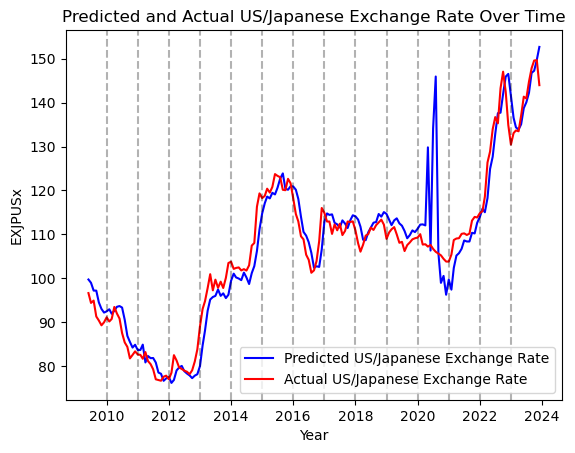

In [76]:
plt.plot(unscaled_preds_df["jp_preds"], color = "blue", label = "Predicted US/Japanese Exchange Rate")
plt.plot(urate_dollar_df["EXJPUSx"][600+5:], color = "red", label = "Actual US/Japanese Exchange Rate")
plt.legend()
plt.xlabel("Year")
plt.ylabel("EXJPUSx")
plt.title("Predicted and Actual US/Japanese Exchange Rate Over Time")
for year in range (urate_dollar_df.index[605].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

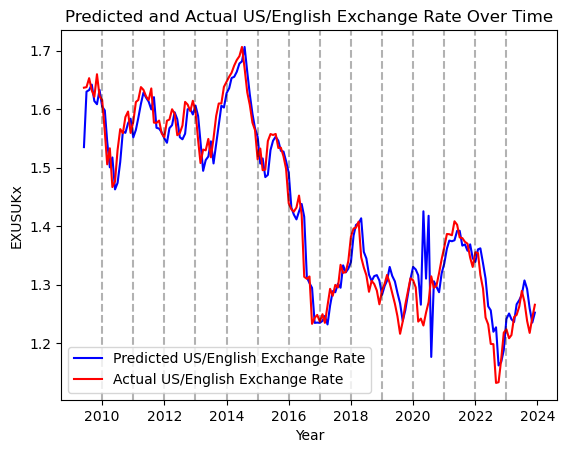

In [77]:
plt.plot(unscaled_preds_df["uk_preds"], color = "blue", label = "Predicted US/English Exchange Rate")
plt.plot(urate_dollar_df["EXUSUKx"][605:], color = "red", label = "Actual US/English Exchange Rate")
plt.legend()
plt.xlabel("Year")
plt.ylabel("EXUSUKx")
plt.title("Predicted and Actual US/English Exchange Rate Over Time")
for year in range (urate_dollar_df.index[605].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

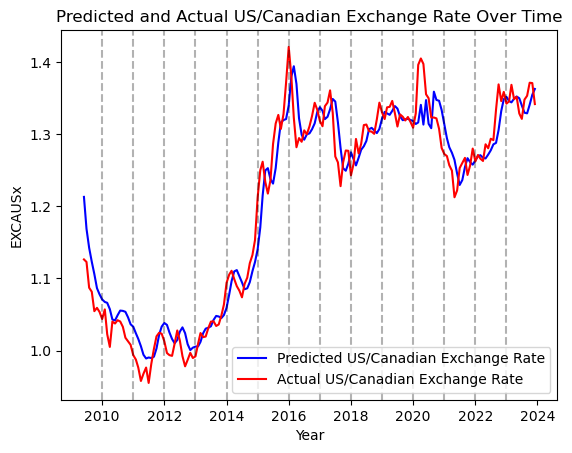

In [78]:
plt.plot(unscaled_preds_df["ca_preds"], color = "blue", label = "Predicted US/Canadian Exchange Rate")
plt.plot(urate_dollar_df["EXCAUSx"][605:], color = "red", label = "Actual US/Canadian Exchange Rate")
plt.legend()
plt.xlabel("Year")
plt.ylabel("EXCAUSx")
plt.title("Predicted and Actual US/Canadian Exchange Rate Over Time")
for year in range (urate_dollar_df.index[605].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

### Predicting Exchange Rates Without Unemplyment Rate

In [80]:
sz_rate_x, sz_rate_y = format_one_variable(fred_md["EXSZUSx"], 5)
jp_rate_x, jp_rate_y = format_one_variable(fred_md["EXJPUSx"], 5)
uk_rate_x, uk_rate_y = format_one_variable(fred_md["EXUSUKx"], 5)
ca_rate_x, ca_rate_y = format_one_variable(fred_md["EXCAUSx"], 5)

In [84]:
cnn_x_sz_train2, cnn_x_sz_val2, cnn_x_sz_test2, cnn_y_sz_train2, cnn_y_sz_val2, cnn_y_sz_test2 = train_val_test(sz_rate_x, sz_rate_y, 500, 600)
cnn_x_jp_train2, cnn_x_jp_val2, cnn_x_jp_test2, cnn_y_jp_train2, cnn_y_jp_val2, cnn_y_jp_test2 = train_val_test(jp_rate_x, jp_rate_y, 500, 600)
cnn_x_uk_train2, cnn_x_uk_val2, cnn_x_uk_test2, cnn_y_uk_train2, cnn_y_uk_val2, cnn_y_uk_test2 = train_val_test(uk_rate_x, uk_rate_y, 500, 600)
cnn_x_ca_train2, cnn_x_ca_val2, cnn_x_ca_test2, cnn_y_ca_train2, cnn_y_ca_val2, cnn_y_ca_test2 = train_val_test(ca_rate_x, ca_rate_y, 500, 600)

In [140]:
def create_cnn2():
    CNN = models.Sequential()
    CNN.add(InputLayer((5, 1)))
    CNN.add(Conv1D(64, kernel_size = 2, activation = "tanh"))
    CNN.add(Flatten())
    CNN.add(Dense(1, "linear"))
    CNN.compile(optimizer='adam', loss='mse')
    return CNN


In [141]:
cnn_sz2 = create_cnn2()
cnn_jp2 = create_cnn2()
cnn_uk2 = create_cnn2()
cnn_ca2 = create_cnn2()

In [142]:
cnn_sz2.fit(cnn_x_sz_train2, cnn_y_sz_train2, validation_data = (cnn_x_sz_val2, cnn_y_sz_val2),epochs=25)
print("SZ done")
cnn_jp2.fit(cnn_x_jp_train2, cnn_y_jp_train2, validation_data = (cnn_x_jp_val2, cnn_y_jp_val2),epochs=100)
print("JP done")
cnn_uk2.fit(cnn_x_uk_train2, cnn_y_uk_train2, validation_data = (cnn_x_uk_val2, cnn_y_uk_val2),epochs=25)
print("UK done")
cnn_ca2.fit(cnn_x_ca_train2, cnn_y_ca_train2, validation_data = (cnn_x_ca_val2, cnn_y_ca_val2),epochs=25)
print("CA done")

Epoch 1/25
16/16 [==============================] - 1s 11ms/step - loss: 3.3974 - val_loss: 0.0112
Epoch 2/25
16/16 [==============================] - 0s 4ms/step - loss: 0.3133 - val_loss: 0.4732
Epoch 3/25
16/16 [==============================] - 0s 4ms/step - loss: 0.2650 - val_loss: 0.1777
Epoch 4/25
16/16 [==============================] - 0s 5ms/step - loss: 0.1614 - val_loss: 0.0877
Epoch 5/25
16/16 [==============================] - 0s 4ms/step - loss: 0.1326 - val_loss: 0.1118
Epoch 6/25
16/16 [==============================] - 0s 5ms/step - loss: 0.1104 - val_loss: 0.0751
Epoch 7/25
16/16 [==============================] - 0s 5ms/step - loss: 0.0909 - val_loss: 0.0556
Epoch 8/25
16/16 [==============================] - 0s 4ms/step - loss: 0.0755 - val_loss: 0.0395
Epoch 9/25
16/16 [==============================] - 0s 5ms/step - loss: 0.0614 - val_loss: 0.0313
Epoch 10/25
16/16 [==============================] - 0s 6ms/step - loss: 0.0506 - val_loss: 0.0192
Epoch 11/25
16/16 

In [143]:
sz_preds2 = cnn_sz2.predict(cnn_x_sz_test2)
jp_preds2 = cnn_jp2.predict(cnn_x_jp_test2)
uk_preds2 = cnn_uk2.predict(cnn_x_uk_test2)
ca_preds2 = cnn_ca2.predict(cnn_x_ca_test2)

preds_dict2 = {
    "sz_preds":sz_preds2.reshape(1,-1)[0],
    "jp_preds":jp_preds2.reshape(1,-1)[0],
    "uk_preds":uk_preds2.reshape(1,-1)[0],
    "ca_preds":ca_preds2.reshape(1,-1)[0],
    "urate":urate_dollar_df.iloc[600+5:,-1],
}
preds_df2 = pd.DataFrame(preds_dict2)

6/6 [==============================] - 0s 4ms/step


In [144]:
preds_df2

,sz_preds,jp_preds,uk_preds,ca_preds,urate
sasdate,,,,,
2009-06-01,1.024216,151.636108,1.520305,1.248629,9.5
2009-07-01,1.020293,150.836731,1.569827,1.226416,9.5
2009-08-01,0.992265,147.042419,1.631211,1.186873,9.6
2009-09-01,0.969028,146.394226,1.672270,1.156714,9.8
2009-10-01,0.946041,145.531738,1.692683,1.134051,10.0
...,...,...,...,...,...
2023-08-01,0.725714,176.866760,1.320697,1.331271,3.8
2023-09-01,0.712582,180.996902,1.334876,1.319530,3.8
2023-10-01,0.702969,182.279770,1.333499,1.317194,3.8


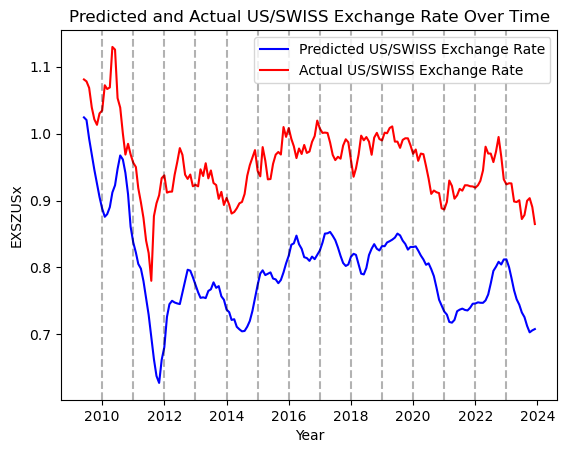

In [145]:
plt.plot(preds_df2["sz_preds"], color = "blue", label = "Predicted US/SWISS Exchange Rate")
plt.plot(urate_dollar_df["EXSZUSx"][605:], color = "red", label = "Actual US/SWISS Exchange Rate")
plt.legend()
plt.xlabel("Year")
plt.ylabel("EXSZUSx")
plt.title("Predicted and Actual US/SWISS Exchange Rate Over Time")
for year in range (urate_dollar_df.index[605].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

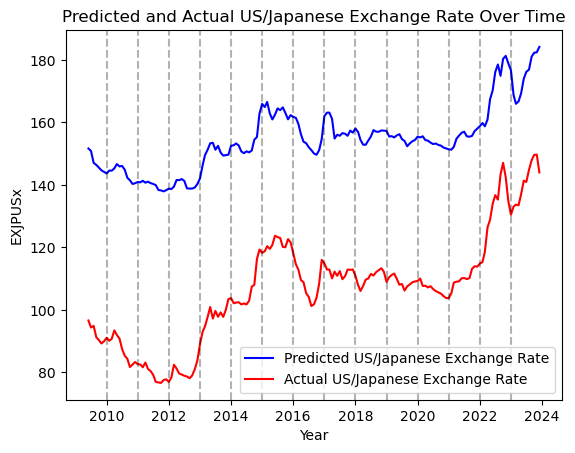

In [146]:
plt.plot(preds_df2["jp_preds"], color = "blue", label = "Predicted US/Japanese Exchange Rate")
plt.plot(urate_dollar_df["EXJPUSx"][605:], color = "red", label = "Actual US/Japanese Exchange Rate")
plt.legend()
plt.xlabel("Year")
plt.ylabel("EXJPUSx")
plt.title("Predicted and Actual US/Japanese Exchange Rate Over Time")
for year in range (urate_dollar_df.index[605].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

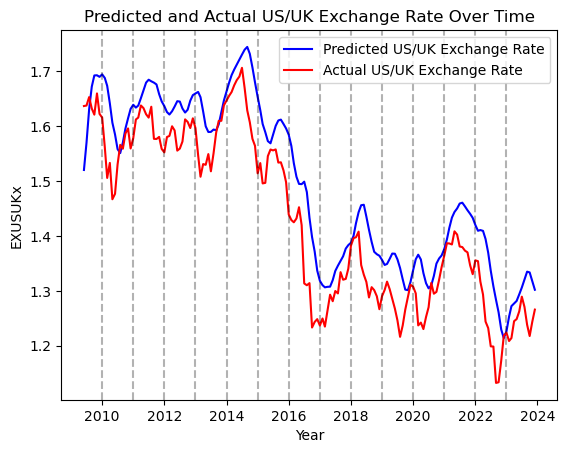

In [147]:
plt.plot(preds_df2["uk_preds"], color = "blue", label = "Predicted US/UK Exchange Rate")
plt.plot(urate_dollar_df["EXUSUKx"][605:], color = "red", label = "Actual US/UK Exchange Rate")
plt.legend()
plt.xlabel("Year")
plt.ylabel("EXUSUKx")
plt.title("Predicted and Actual US/UK Exchange Rate Over Time")
for year in range (urate_dollar_df.index[605].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

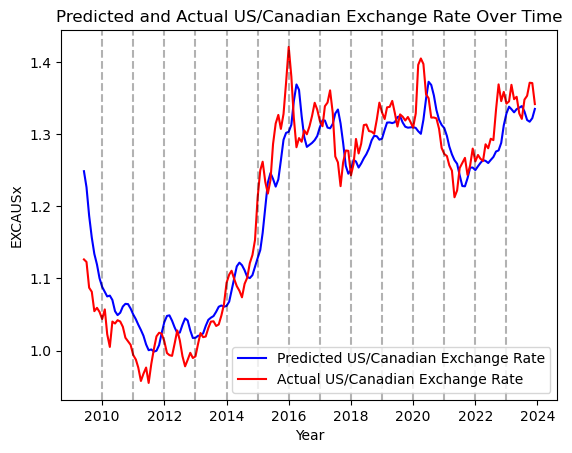

In [148]:
plt.plot(preds_df2["ca_preds"], color = "blue", label = "Predicted US/Canadian Exchange Rate")
plt.plot(urate_dollar_df["EXCAUSx"][605:], color = "red", label = "Actual US/Canadian Exchange Rate")
plt.legend()
plt.xlabel("Year")
plt.ylabel("EXCAUSx")
plt.title("Predicted and Actual US/Canadian Exchange Rate Over Time")
for year in range (urate_dollar_df.index[605].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

### RPI and M1 Stock

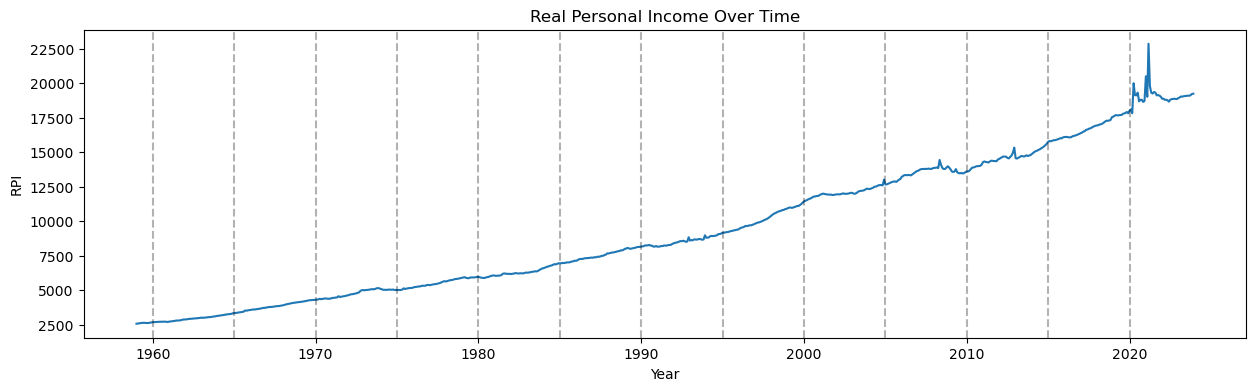

In [209]:
title_ = fred_md_metadata.loc[fred_md_metadata["fred"] == "RPI", "description"].values[0]
plt.figure(figsize=(15,4))
plt.plot(fred_md["RPI"])
plt.title(f"{title_} Over Time")
plt.xlabel("Year")
plt.ylabel(f"RPI")
for year in range (urate_dollar_df.index[0].year+1,urate_dollar_df.index[-1].year +1, 5):
    plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

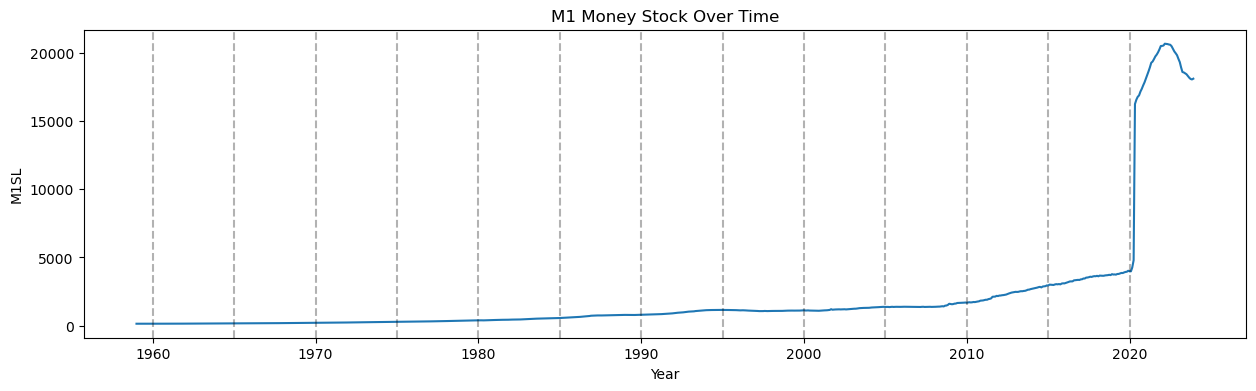

In [210]:
title_ = fred_md_metadata.loc[fred_md_metadata["fred"] == "M1SL", "description"].values[0]
plt.figure(figsize=(15,4))
plt.plot(fred_md["M1SL"])
plt.title(f"{title_} Over Time")
plt.xlabel("Year")
plt.ylabel(f"M1SL")
for year in range (urate_dollar_df.index[0].year+1,urate_dollar_df.index[-1].year +1, 5):
    plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

In [211]:
m1_rpi = fred_md[["RPI", "M1SL"]]
scaler4 = StandardScaler()
scaled_np4 = scaler4.fit_transform(m1_rpi.to_numpy())
scaled_df4 = pd.DataFrame(scaled_np4, columns = ["RPI", "M1SL"])
scaled_df4.index = urate_dollar_df.index
scaled_df4.tail()


,RPI,M1SL
sasdate,,
2023-08-01,1.972238,3.809722
2023-09-01,1.970259,3.778808
2023-10-01,1.979457,3.757511
2023-11-01,1.997052,3.749302
2023-12-01,2.000565,3.762320


In [218]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

TRAIN, VAL = 499, 600

x_train4, y_train4 = df_to_X_y(scaled_df4, 5)
x_train4_, x_val4, x_test4 = x_train4[:TRAIN], x_train4[TRAIN:VAL], x_train4[VAL:]
y_train4_, y_val4, y_test4 = y_train4[:TRAIN], y_train4[TRAIN:VAL], y_train4[VAL:]

In [219]:
def create_cnn4():
    cnn = models.Sequential()
    cnn.add(InputLayer((5, 2)))
    cnn.add(Conv1D(64, kernel_size = 2, activation="tanh"))
    cnn.add(Flatten())
    cnn.add(Dense(8, "relu"))
    cnn.add(Dense(1, "linear"))
    cnn.compile(optimizer='adam', loss='mse')
    return cnn

def create_gru4():
    gru = models.Sequential()
    gru.add(InputLayer((5, 2)))
    gru.add(GRU(64))
    gru.add(Dense(8, "relu"))
    gru.add(Dense(1, "linear"))
    gru.compile(optimizer='adam', loss='mse')
    return gru

def create_lstm4():
    lstm = models.Sequential()
    lstm.add(InputLayer((5, 2)))
    lstm.add(LSTM(64))
    lstm.add(Dense(8, "relu"))
    lstm.add(Dense(1, "linear"))
    lstm.compile(optimizer='adam', loss='mse')
    return lstm

def double_lstm():
    lstm = models.Sequential()
    lstm.add(InputLayer((5, 2)))
    lstm.add(LSTM(32, return_sequences = True))
    lstm.add(LSTM(64))
    lstm.add(Dense(8, "relu"))
    lstm.add(Dense(1, "linear"))
    lstm.compile(optimizer='adam', loss='mse')
    return lstm

In [220]:
cnn4 = create_cnn4()
gru4 = create_gru4()
lstm4 = create_lstm4()
double_lstm4 = double_lstm()

In [221]:
cnn4.fit(x_train4, y_train4, validation_data = (x_val4, y_val4), epochs = 15)
gru4.fit(x_train4, y_train4, validation_data = (x_val4, y_val4), epochs = 15)
lstm4.fit(x_train4, y_train4, validation_data = (x_val4, y_val4), epochs = 15)
double_lstm4.fit(x_train4, y_train4, validation_data = (x_val4, y_val4), epochs = 15)

Epoch 1/15
25/25 [==============================] - 1s 9ms/step - loss: 0.3979 - val_loss: 0.0528
Epoch 2/15
25/25 [==============================] - 0s 5ms/step - loss: 0.0219 - val_loss: 0.0021
Epoch 3/15
25/25 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 9.0600e-04
Epoch 4/15
25/25 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 6.7232e-04
Epoch 5/15
25/25 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 6.7124e-04
Epoch 6/15
25/25 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 6.6418e-04
Epoch 7/15
25/25 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 6.6463e-04
Epoch 8/15
25/25 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 7.3304e-04
Epoch 9/15
25/25 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 6.4725e-04
Epoch 10/15
25/25 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss

In [222]:
cnn4_preds = cnn4.predict(x_test4)
gru4_preds = gru4.predict(x_test4)
lstm4_preds = lstm4.predict(x_test4)
double_lstm4_preds = double_lstm4.predict(x_test4)

6/6 [==============================] - 1s 3ms/step


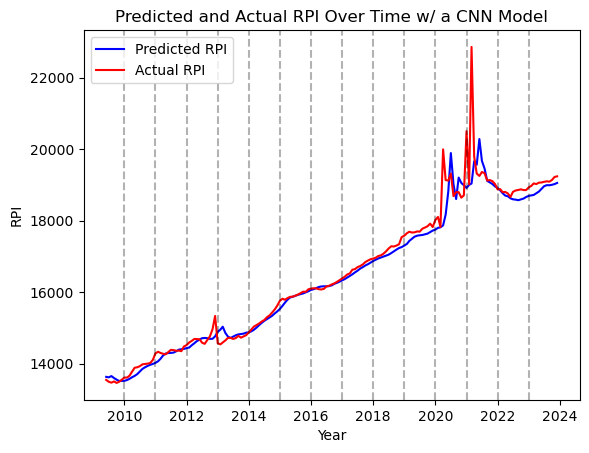

In [223]:

preds_cnn_dict = {
    "CNN_Preds":cnn4_preds.reshape(1,-1)[0],
    "M1":scaled_np4[VAL+5:,-1].reshape(1,-1)[0],
}

preds_cnn_dict
unscaled_preds_cnn = scaler4.inverse_transform(pd.DataFrame(preds_cnn_dict).to_numpy())
unscaled_preds_df = pd.DataFrame(unscaled_preds_cnn, columns = ["CNN_Preds", "M1"])
unscaled_preds_df.index = fred_md.index[VAL+5:]

plt.plot(unscaled_preds_df["CNN_Preds"], color = "blue", label = "Predicted RPI")
plt.plot(fred_md["RPI"][VAL+5:], color = "red", label = "Actual RPI")
plt.legend()
plt.xlabel("Year")
plt.ylabel("RPI")
plt.title("Predicted and Actual RPI Over Time w/ a CNN Model")
for year in range (urate_dollar_df.index[VAL].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

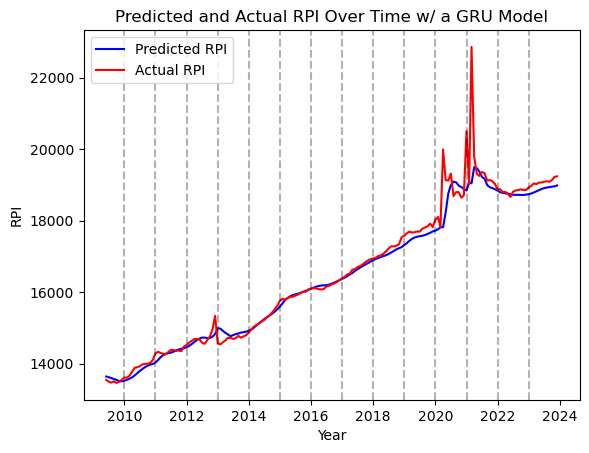

In [224]:
preds_gru_dict = {
    "GRU_Preds":gru4_preds.reshape(1,-1)[0],
    "M1":scaled_np4[VAL+5:,-1].reshape(1,-1)[0],
}

unscaled_preds_gru = scaler4.inverse_transform(pd.DataFrame(preds_gru_dict).to_numpy())
unscaled_preds_df2 = pd.DataFrame(unscaled_preds_gru, columns = ["GRU_Preds", "M1"])
unscaled_preds_df2.index = fred_md.index[VAL+5:]

plt.plot(unscaled_preds_df2["GRU_Preds"], color = "blue", label = "Predicted RPI")
plt.plot(fred_md["RPI"][VAL+5:], color = "red", label = "Actual RPI")
plt.legend()
plt.xlabel("Year")
plt.ylabel("RPI")
plt.title("Predicted and Actual RPI Over Time w/ a GRU Model")
for year in range (urate_dollar_df.index[VAL].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

In [225]:
preds_lstm_dict = {
    "LSTM_Preds":lstm4_preds.reshape(1,-1)[0],
    "M1":scaled_np4[VAL+5:,-1].reshape(1,-1)[0],
}

unscaled_preds_lstm = scaler4.inverse_transform(pd.DataFrame(preds_lstm_dict).to_numpy())
unscaled_preds_df3 = pd.DataFrame(unscaled_preds_lstm, columns = ["LSTM_Preds", "M1"])
unscaled_preds_df3.index = fred_md.index[VAL+5:]

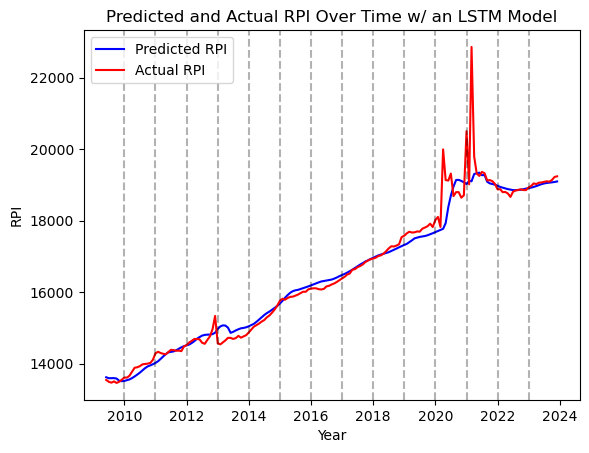

In [226]:
plt.plot(unscaled_preds_df3["LSTM_Preds"], color = "blue", label = "Predicted RPI")
plt.plot(fred_md["RPI"][VAL+5:], color = "red", label = "Actual RPI")
plt.legend()
plt.xlabel("Year")
plt.ylabel("RPI")
plt.title("Predicted and Actual RPI Over Time w/ an LSTM Model")
for year in range (urate_dollar_df.index[VAL].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

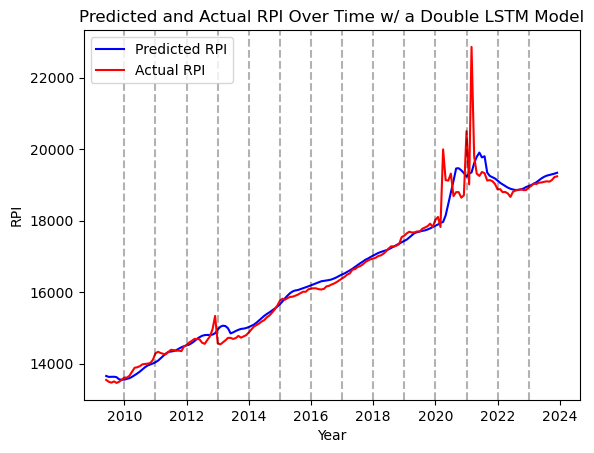

In [227]:
preds_double_lstm_dict = {
    "Double_LSTM_Preds":double_lstm4_preds.reshape(1,-1)[0],
    "M1":scaled_np4[VAL+5:,-1].reshape(1,-1)[0],
}

unscaled_preds_double_lstm = scaler4.inverse_transform(pd.DataFrame(preds_double_lstm_dict).to_numpy())
unscaled_preds_df4 = pd.DataFrame(unscaled_preds_double_lstm, columns = ["Double_LSTM_Preds", "M1"])
unscaled_preds_df4.index = fred_md.index[VAL+5:]

plt.plot(unscaled_preds_df4["Double_LSTM_Preds"], color = "blue", label = "Predicted RPI")
plt.plot(fred_md["RPI"][VAL+5:], color = "red", label = "Actual RPI")
plt.legend()
plt.xlabel("Year")
plt.ylabel("RPI")
plt.title("Predicted and Actual RPI Over Time w/ a Double LSTM Model")
for year in range (urate_dollar_df.index[VAL].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

In [228]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print(mean_absolute_percentage_error(unscaled_preds_df["CNN_Preds"], fred_md["RPI"][VAL+5:]))
print(mean_absolute_percentage_error(unscaled_preds_df2["GRU_Preds"], fred_md["RPI"][VAL+5:]))
print(mean_absolute_percentage_error(unscaled_preds_df3["LSTM_Preds"], fred_md["RPI"][VAL+5:]))
print(mean_absolute_percentage_error(unscaled_preds_df4["Double_LSTM_Preds"], fred_md["RPI"][VAL+5:]))

0.010388273904977806
0.009469761576509996
0.01083998721836924
0.010879596655241512


### LSTM to Forecast Interest Rates

In [232]:
fed_ir = pd.DataFrame(fred_md["FEDFUNDS"])
fed_ir.head()

,FEDFUNDS
sasdate,
1959-01-01,2.48
1959-02-01,2.43
1959-03-01,2.80
1959-04-01,2.96
1959-05-01,2.90


In [374]:
from keras.regularizers import l1, l2
def create_lstm5():
    lstm = models.Sequential()
    lstm.add(InputLayer((5,1)))
    lstm.add(LSTM(32))
    lstm.add(Dense(4,"relu"))
    lstm.add(Dense(1,"linear"))
    lstm.compile(optimizer="adam", loss="mse")
    return lstm

In [375]:
ir_x, ir_y = format_one_variable(fed_ir, window_size=5)
ir_x.shape


(775, 5, 1)

In [376]:
ir_x_train, ir_x_val, ir_x_test, ir_y_train, ir_y_val, ir_y_test = train_val_test(ir_x, ir_y, TRAIN, VAL)
ir_x_train.shape, ir_y_train.shape

((499, 5, 1), (499,))

In [377]:
lstm5 = create_lstm5()
lstm5.fit(ir_x_train, ir_y_train, validation_data = (ir_x_val, ir_y_val), epochs=100)

Epoch 1/100
16/16 [==============================] - 3s 46ms/step - loss: 46.6312 - val_loss: 6.6683
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 38.6254 - val_loss: 3.6342
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 28.5613 - val_loss: 1.5539
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 19.0011 - val_loss: 1.9853
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 12.4977 - val_loss: 4.4831
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 9.6251 - val_loss: 4.9831
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 8.2137 - val_loss: 2.9783
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 6.5044 - val_loss: 0.9799
Epoch 9/100
16/16 [==============================] - 0s 12ms/step - loss: 4.9612 - val_loss: 0.6411
Epoch 10/100
16/16 [==============================] - 0s 12ms/step - loss: 3.5972 - val_loss: 0.2

6/6 [==============================] - 1s 4ms/step
0.17636198624827926


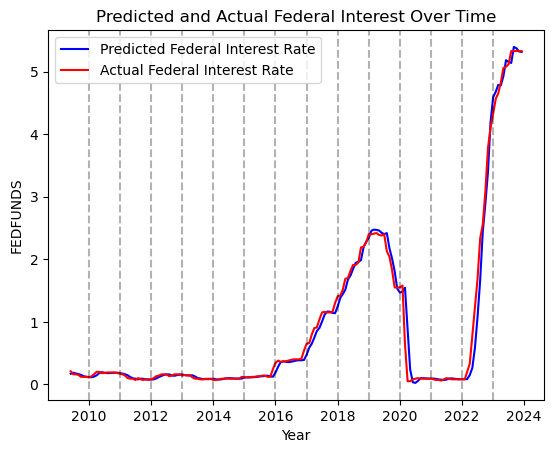

In [378]:
fed_ir_preds = lstm5.predict(ir_x_test)
preds_ir_dict = {
    "FED_IR_Preds":fed_ir_preds.reshape(1,-1)[0],
    "Real_FED_IR":fed_ir.iloc[VAL+5:,-1],
}

fed_ir_preds_df = pd.DataFrame(preds_ir_dict)
fed_ir_preds_df.head()

plt.plot(fed_ir_preds_df["FED_IR_Preds"], color = "blue", label = "Predicted Federal Interest Rate")
plt.plot(fed_ir_preds_df["Real_FED_IR"], color = "red", label = "Actual Federal Interest Rate")
plt.legend()
plt.xlabel("Year")
plt.ylabel("FEDFUNDS")
plt.title("Predicted and Actual Federal Interest Over Time")
for year in range (urate_dollar_df.index[600].year+1,urate_dollar_df.index[-1].year +1, 1):
        plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)
        
print(mean_absolute_percentage_error(fed_ir_preds_df["FED_IR_Preds"], fed_ir_preds_df["Real_FED_IR"]))